In [1]:
%matplotlib inline
%matplotlib nbagg

from typing import *
from IPython.display import Image, display, clear_output

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device="cpu"
print(f">> Using device: {device}")

>> Using device: cuda:0


# 1. Introduction

##  1.1) Load data

Load the EEG data using our dataloader. The python scipt for generating dataset can be found in the Code folder, as well as a dataloader function building on work done by David Enslev s123997. The batch_loader is a function for class made for loading our dataset.

In [2]:
from Code.Dataloader import batch_loader
Data_train_path=r"C:/Users/Andre/Desktop/VAE/Fourier_0_overlab_70_30_split_train"
Data_validation_path=r"C:/Users/Andre/Desktop/VAE/Fourier_0_overlab_70_30_split_validation"

train_set=batch_loader(Data_train_path,device)
train_set.pre_load()
print(train_set.data_size)

validation_set=batch_loader(Data_validation_path,device)
validation_set.pre_load()
print(validation_set.data_size)


6246
2412


## 1.2) Plot randomly chosen samples on a grid

# 2. VAE Implementation

We made a pipeline for training VAE models, that can be found in the code as Experiment_setup.py 
Our VAE implementation can be seen in VAE.py

In [3]:
from Code.Experiment_setup import VEA_experiment
from Code.VAE import VariationalAutoencoder, VariationalInference

In [4]:
#Difine some paths for saving the results
save_path=r"Dense3/"
Experiment_name=r"test"

## 2.1 Setting up the model

In [5]:
#Difine hyper paremeters
batch_size=32
n_batches=10  #How many batches for each epochs
latent_features=2 #Number of dimensions on latent layer
beta=0.1

VAE_EX=VEA_experiment(Data_loader_train=train_set,Data_loader_validation=validation_set,batch_size=batch_size,
                  n_batches=n_batches,latent_features=latent_features,beta=beta)
#VAE_EX.make_logfile(save_path+Experiment_name+"_log.txt","Test")

In [6]:
from torch import nn
encoder = nn.Sequential(
    nn.Linear(in_features=4750, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256,out_features=128),
    nn.ReLU(),
    # A Gaussian is fully characterised by its mean \mu and variance \sigma**2
    nn.Linear(in_features=128, out_features=2 * latent_features)  # <- note the 2*latent_features
)

decoder = nn.Sequential(
    nn.Linear(in_features=latent_features, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=4750*2)
)


#Replace the encoder and decoder
VAE_EX.swap_nn(encoder,decoder,flaten=True)

VariationalAutoencoder(
  (vi): VariationalInference()
  (encoder): Sequential(
    (0): Linear(in_features=4750, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=9500, bias=True)
  )
)


### Plot raw data and untrained data

<IPython.core.display.Javascript object>


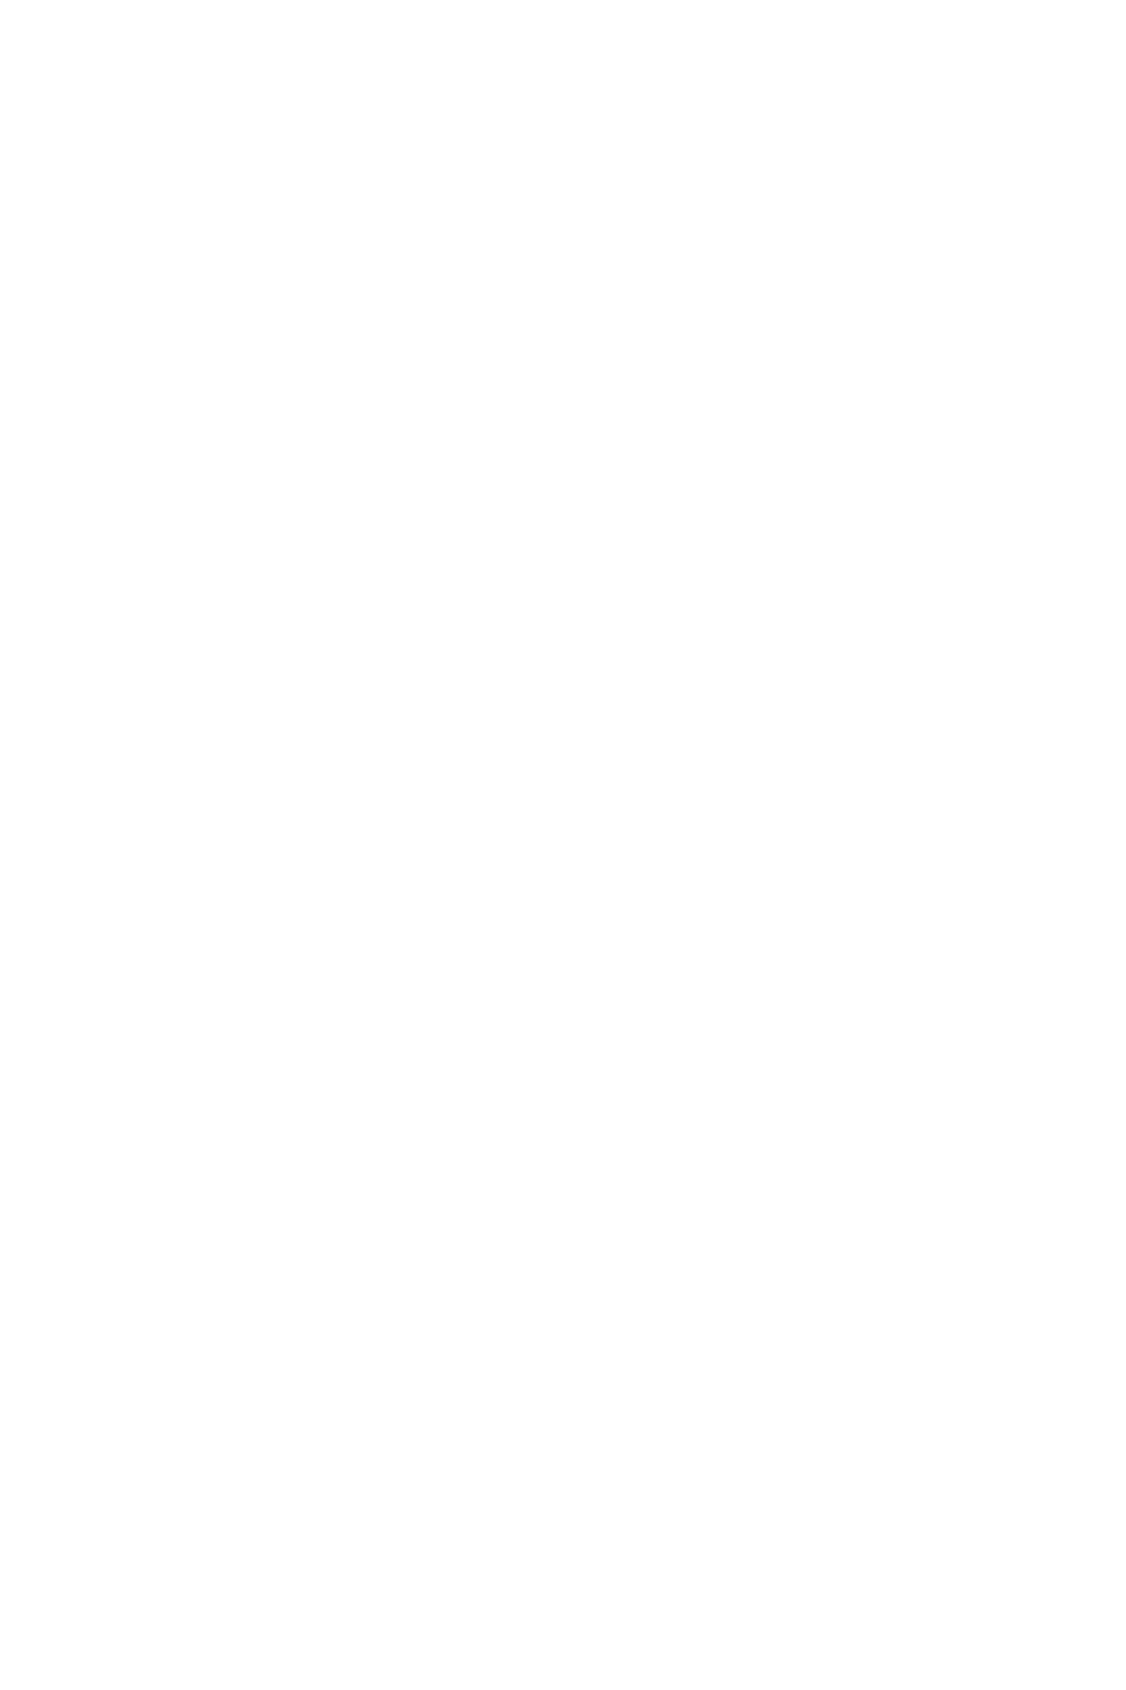

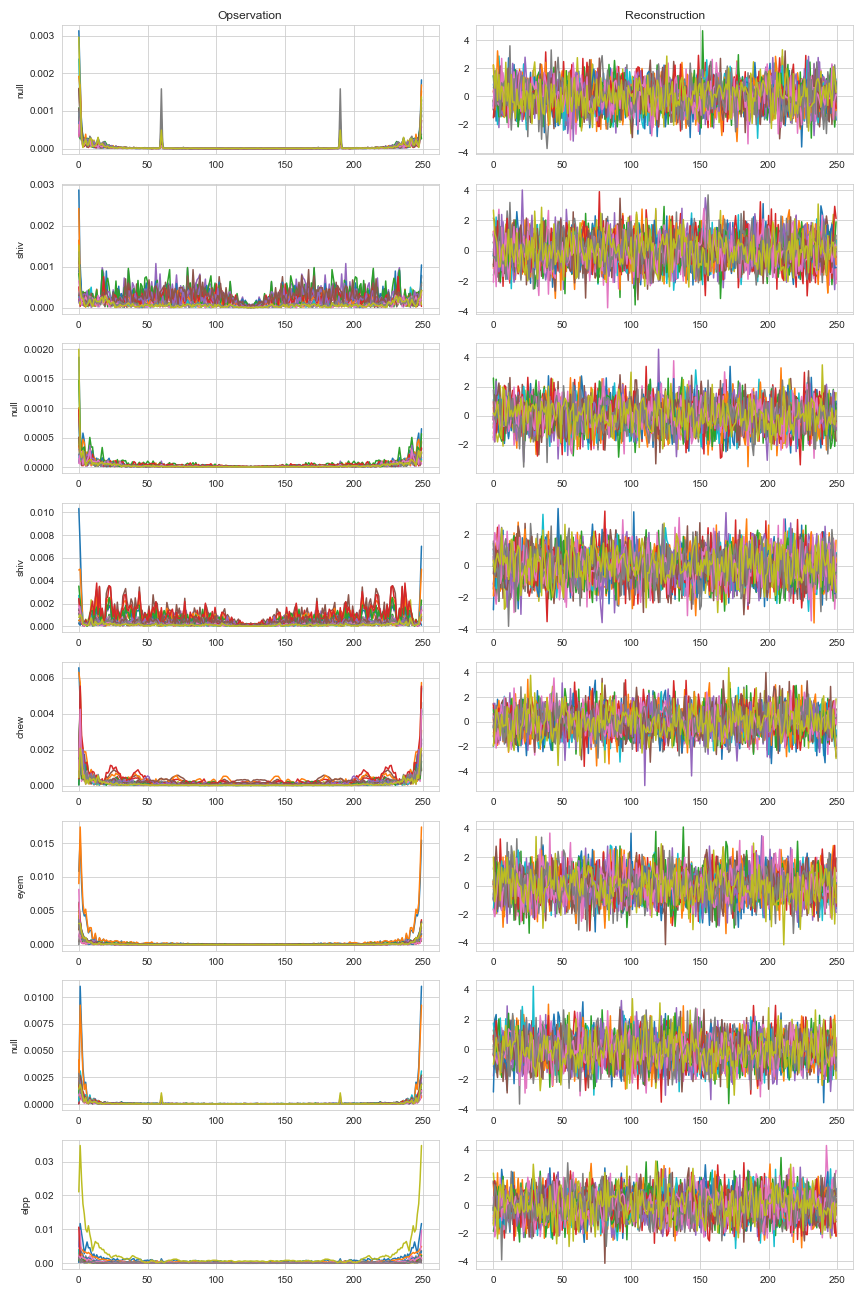

In [10]:
from Code.MNEplotter import plot_batch
X,Y,meta=validation_set.load_random(8,encoded=False)
X_new=VAE_EX.VAE.sample(X)
plot_batch(X.cpu(),X_new.cpu(),Y,show=True)

## 2.2 training the model

Epoch 0/100
Epoch 10/100
Epoch 20/100
Epoch 30/100
Epoch 40/100
Epoch 50/100
Epoch 60/100
Epoch 70/100
Epoch 80/100
Epoch 90/100


<IPython.core.display.Javascript object>


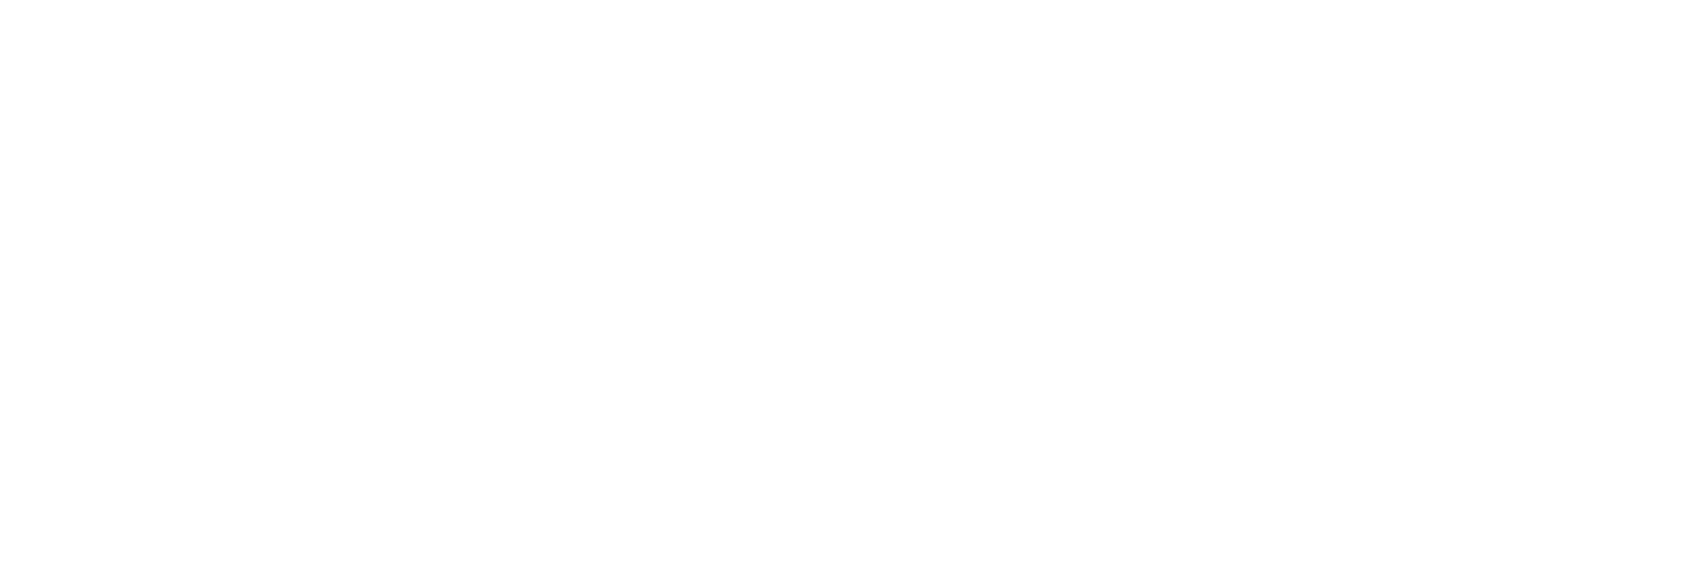

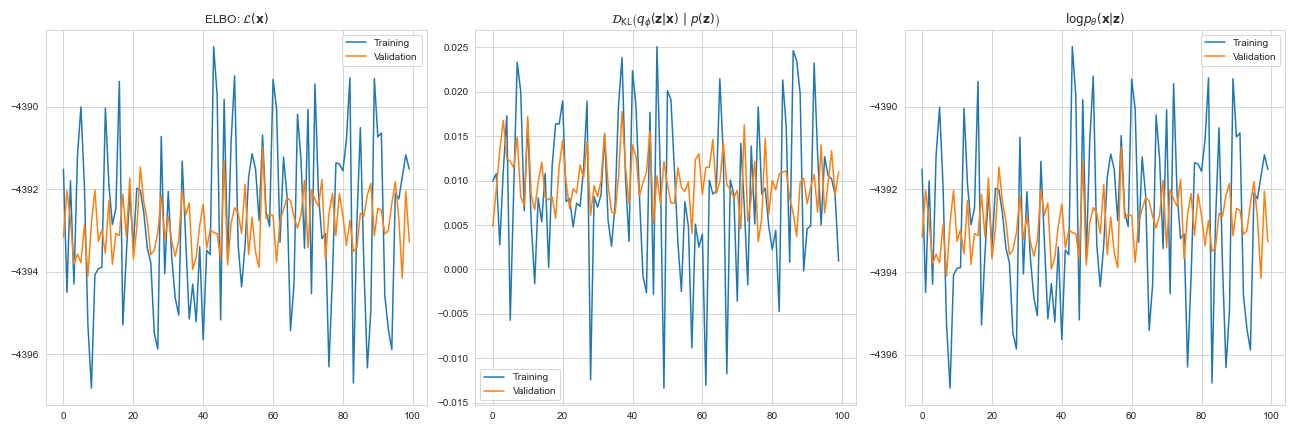

In [7]:
n_epoke=100
VAE_EX.run(num_epochs=n_epoke)
VAE_EX.plot_history(save_path+Experiment_name+"_history.png")
display(Image(save_path+Experiment_name+"_history.png"))

Save the model or load an old one.

In [24]:

# save model
torch.save(VAE_EX.VAE.state_dict(), save_path+Experiment_name+"_model.pt")


In [25]:

# load prtained model
VAE_EX.VAE.load_state_dict(torch.load(save_path+Experiment_name+"_model.pt"))


<All keys matched successfully>

### 5.(Report)Evaluate the trained model on the test set and report the number.

 

<IPython.core.display.Javascript object>


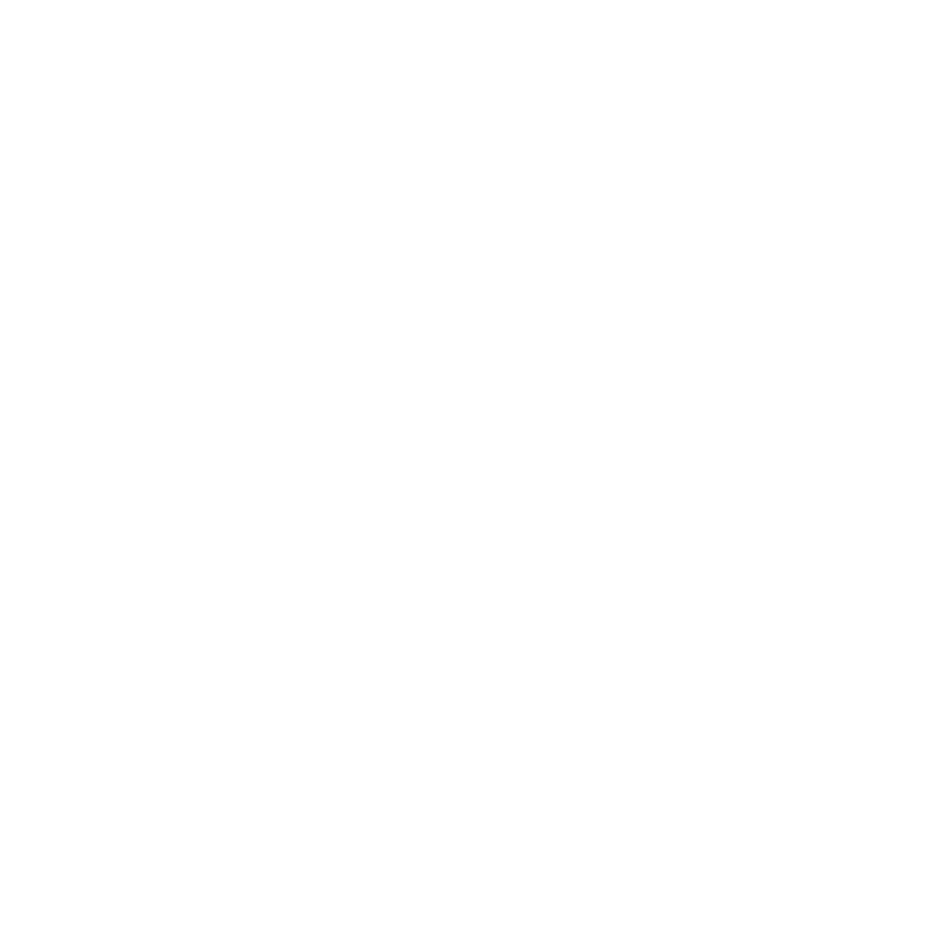

torch.Size([32, 2])


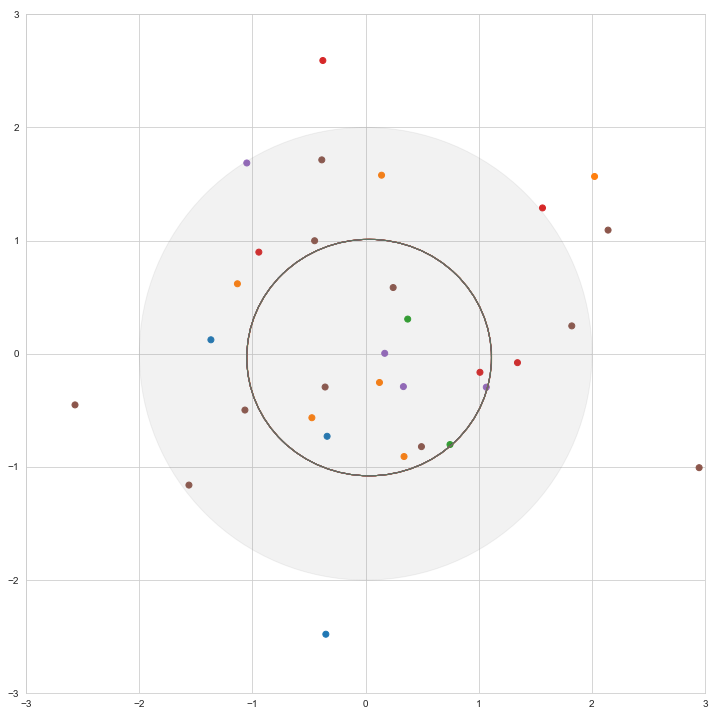

In [8]:
#Evaluate latent space
VAE_EX.show_plots(32)

<IPython.core.display.Javascript object>


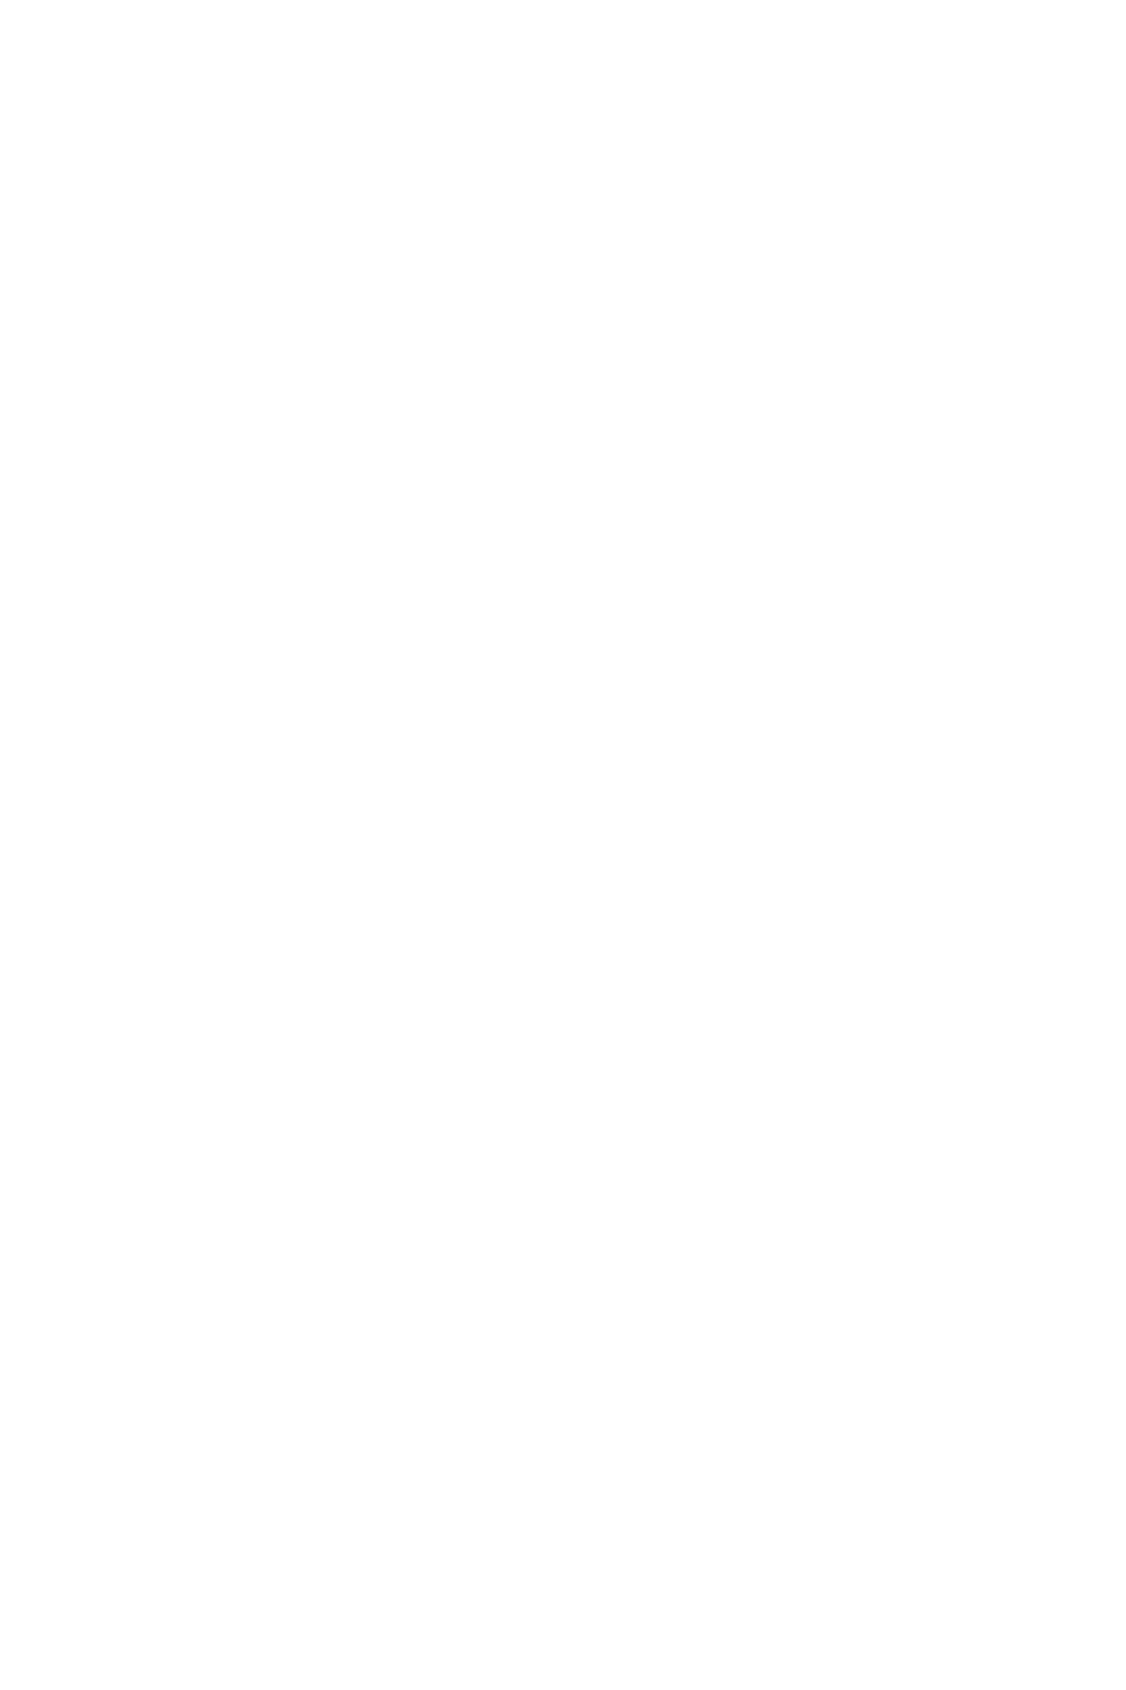

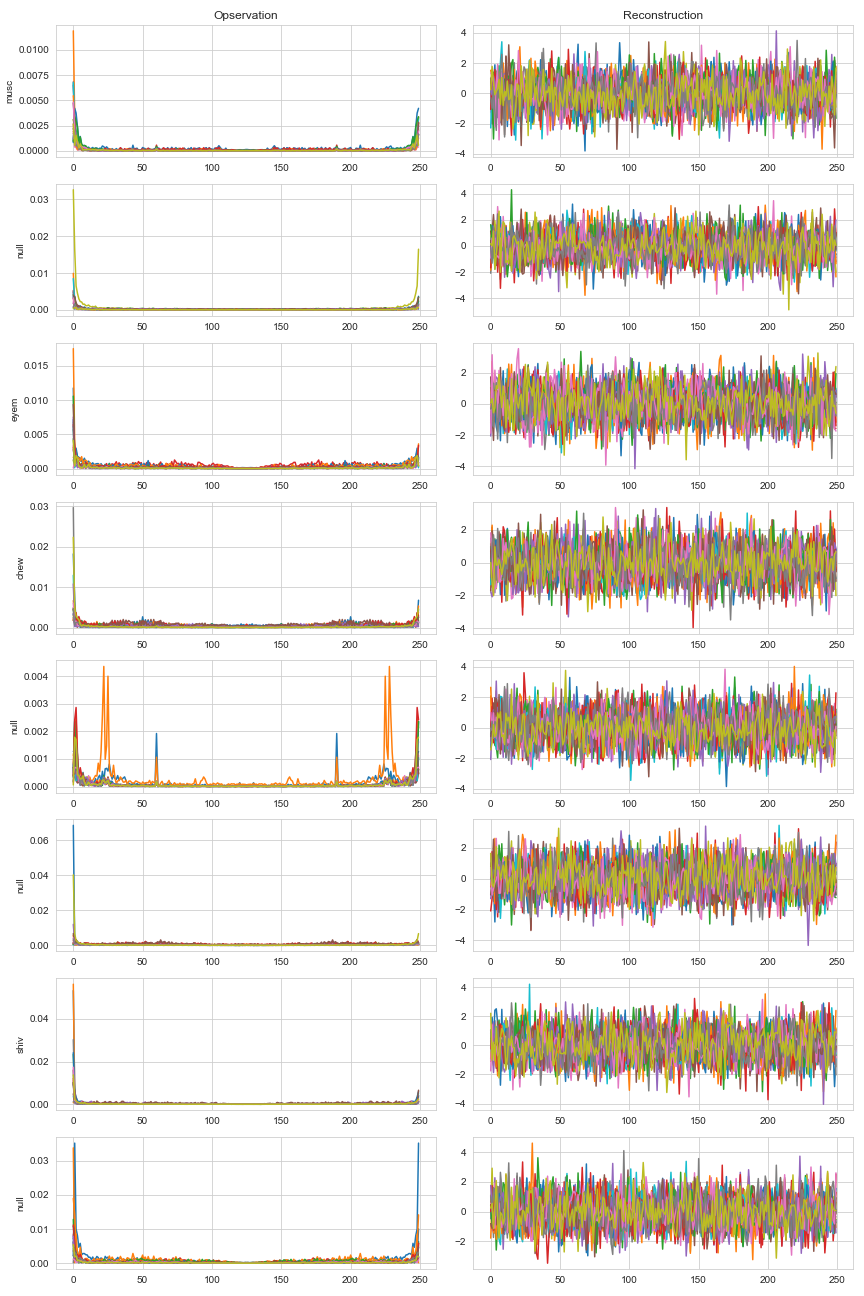

In [11]:
#Plot a sample and its reconstrution

X,Y,meta=validation_set.load_random(8,encoded=False)
X_new=VAE_EX.VAE.sample(X)
plot_batch(X.cpu(),X_new.cpu(),Y,show=True)
#plot_samples(X.cpu(),"")
#plot_samples(untrained_samples.cpu(),"")

# 2.3  Semi-Supervised VAE (M1)

We have now trained a VAE on the full unlabeled dataset.  We will now implement the M1 modelfromSemi-Supervised Learning with Deep Generative Models. This amounts to simply traininga classifier on top of the representations learned by our VAE.

In [12]:
#Move VAE and load data to cpu.
device="cpu"
VAE=VAE_EX.VAE.cpu()
train_set.device=device
validation_set.device=device

### 2.(Report)Train a classifier on their latent representation.  First try a linear classifier and thenexperiment with other types of classifiers.  Report the accuracies.

In [89]:

x_train,y_train,meta_train=train_set.load_all(encoded=False)
z_train=VAE.sample(x_train,z=True)

x_val,y_val,meta_val=validation_set.load_all(encoded=False)
z_val = VAE.sample(x_val, z = True)

In [55]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
import seaborn as sn
import matplotlib.pyplot as plt
def evaluate(y_true, y_pred, print_cm=False, print_err=False):
    
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    names = ["null","eyem","chew","shiv","elpp","musc"]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_cm:
        ax=plt.subplots()
        sn.heatmap(cm, annot=True, xticklabels=names, yticklabels=names, cmap = 'Reds', fmt = 'd')
        #ax.set_xlabel('Predicted');
        #ax.set_ylabel('True'); 
        

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    if print_err:
        print("")
        print("accuracy:", accuracy)
        print("precision:", precision)
        print("recall:", recall)
        print("f1 score:", f1)
        
    return [accuracy,precision,recall,f1]

### a) Linear classifier: SVM

**[SKIP]** Skip this section if training is not needed.

['elpp' 'shiv' 'chew' ... 'musc' 'shiv' 'shiv']


<IPython.core.display.Javascript object>


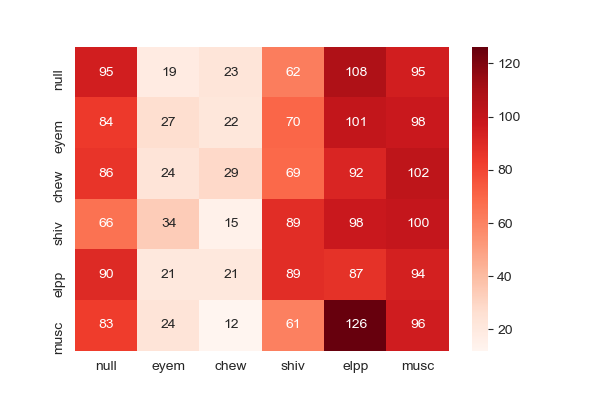

In [74]:
from sklearn import svm

clf = svm.SVC() 
SVM = clf.fit(z_train,y_train)
y_pred = SVM.predict(z_val)
_=evaluate(y_val, y_pred, print_cm=True,print_err=False)

### b) Random Forest

In [57]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier()
RF.fit(z_train,y_train)

RandomForestClassifier()

<IPython.core.display.Javascript object>


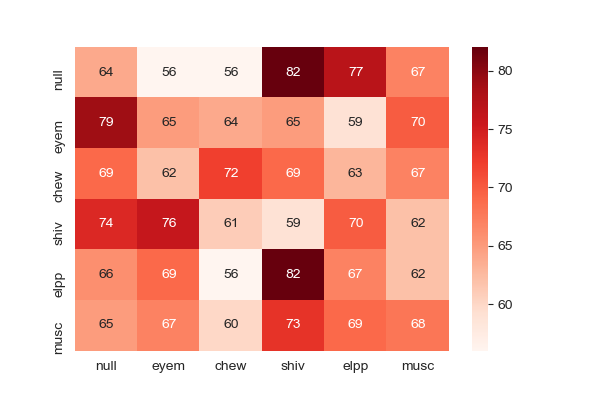

In [58]:
y_pred = RF.predict(z_val)
_=evaluate(y_val, y_pred, print_cm=True,print_err=False)

## b) Neural Network

In [79]:
#Hyperparameters
from torch.nn import Linear, BatchNorm1d
from torch.nn.functional import relu, softmax
num_classes = 6
num_hidden_l1 = 500
num_hidden_l2 = 200
num_features = z_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_output):
        super(Net, self).__init__()  
        
        self.l_1 = nn.Linear(in_features=num_features, 
                          out_features=num_hidden_l1,
                          bias=True)
        
        self.l_2 = nn.Linear(in_features=num_hidden_l1, 
                          out_features=num_hidden_l2,
                          bias=True)
        
        self.l_out = Linear(in_features=num_hidden_l2, 
                            out_features=num_classes,
                            bias=False)

        self.drop_layer  = nn.Dropout(0.5) # Add dropout layer

        self.batchnorm_1 = BatchNorm1d(num_hidden_l1)
        self.batchnorm = BatchNorm1d(num_hidden_l1)

        # define activation function in constructor

    def forward(self, x):

        x = relu(self.l_1(x))
        x = relu(self.l_2(x))
        return softmax(self.l_out(x))

net = Net(num_features, num_classes)
print(net)

Net(
  (l_1): Linear(in_features=2, out_features=500, bias=True)
  (l_2): Linear(in_features=500, out_features=200, bias=True)
  (l_out): Linear(in_features=200, out_features=6, bias=False)
  (drop_layer): Dropout(p=0.5, inplace=False)
  (batchnorm_1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [80]:
import torch.optim as optim
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.05) # Add momentum
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=1e-6) # use Adama instead # Use L2 regularization
criterion = nn.CrossEntropyLoss()

In [82]:
x_train,y_train,meta_train=train_set.load_all(encoded=True)
y_train=torch.argmax(y_train,dim=1)
z_train=VAE.sample(x_train,z=True)

x_valid,y_valid,meta_train=train_set.load_all(encoded=True)
y_valid=torch.argmax(y_valid,dim=1)
z_valid=VAE.sample(x_valid,z=True)

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch  0 : Train Loss 4.656874 , Train acc 0.167903, Valid acc 0.167903
Epoch 10 : Train Loss 4.651711 , Train acc 0.167903, Valid acc 0.167903
Epoch 20 : Train Loss 4.670110 , Train acc 0.160484, Valid acc 0.160484
Epoch 30 : Train Loss 4.642205 , Train acc 0.172258, Valid acc 0.172097
Epoch 40 : Train Loss 4.628585 , Train acc 0.176774, Valid acc 0.170968
Epoch 50 : Train Loss 4.654847 , Train acc 0.169194, Valid acc 0.172419
Epoch 60 : Train Loss 4.652489 , Train acc 0.169355, Valid acc 0.173065
Epoch 70 : Train Loss 4.651711 , Train acc 0.167903, Valid acc 0.167903
Epoch 80 : Train Loss 4.651711 , Train acc 0.167903, Valid acc 0.167903
Epoch 90 : Train Loss 4.651711 , Train acc 0.167903, Valid acc 0.167903


<IPython.core.display.Javascript object>


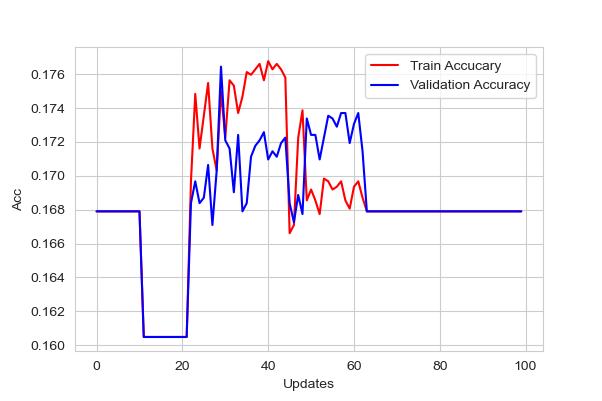

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

In [83]:
# we could have done this ourselves,
# but we should be aware of sklearn and its tools
from sklearn.metrics import accuracy_score


# setting hyperparameters and gettings epoch sizes
batch_size = 50
num_epochs = 100
num_samples_train = z_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = z_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(z_train[slce]).type(torch.float)
        y_pred = torch.argmax(output, dim =1)
        
        # compute gradients given loss
        target_batch = y_train[slce].type(torch.long)

        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(z_train[slce])
        y_pred = torch.argmax(output, dim =1)
        
        train_targs += list(y_train[slce].numpy())
        train_preds += list(y_pred.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(z_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(y_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


<IPython.core.display.Javascript object>


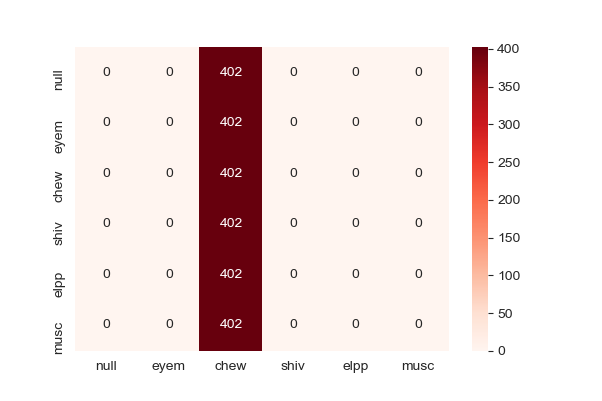

C:\Users\Andre\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



accuracy: 0.16666666666666666
precision: 0.0
recall: 0.0
f1 score: nan


C:\Users\Andre\anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


[0.16666666666666666, 0.0, 0.0, nan]

In [92]:
y_out = net(z_val)
names = ["null","eyem","chew","shiv","elpp","musc"]
y_pred = [names[l] for l in torch.argmax(y_out, dim =1).detach().numpy()]
evaluate(y_val, y_pred, print_cm=True,print_err=True)